In [2]:
from astropy.table import *
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from astropy.table import hstack
import os
from scipy.stats import binned_statistic
import matplotlib
import matplotlib.backends.backend_pdf

plt.rc('font', family='serif'), plt.rc('xtick', labelsize=18), plt.rc('ytick', labelsize=18)
plt.rcParams['savefig.dpi'] = 300
plt.rc('text',usetex=True)
matplotlib.rcParams['xtick.direction'] = 'in'
matplotlib.rcParams['ytick.direction'] = 'in'
np.set_printoptions(precision=3)

#### add lp_mass 16-84 range in trimed C20_classic catalog

In [ ]:
# add lp_mass 16-84 range
cat_1 = Table.read('/Volumes/LejaySSD/COSMOS2020/COSMOS2020_CLASSIC_R1_v2.0_15bands_photoz_added.fits')
cat_2 = Table.read('/Volumes/LejaySSD/COSMOS2020/COSMOS2020_CLASSIC_R1_v2.0.fits')
if 'lp_mass_med_min68' not in cat_1.keys():
    cat_1.add_column(cat_2['lp_mass_med_min68'])
    cat_1.add_column(cat_2['lp_mass_med_max68'])
    cat_1.write('/Volumes/LejaySSD/COSMOS2020/COSMOS2020_CLASSIC_R1_v2.0_15bands_photoz_added.fits',overwrite=True)

#### compare C20 mass internally
between 4 configurations:

1. FARMER + LePhare
2. FARMER + EAzY
3. SEXtractor + LePhare
4. SEXtractor + EAzY

flag_photoz: a flag for photoz consistency,  0=bad-z, 1=good-z, -99=not matched

In [5]:
# match classic & farmer catalog (v2.2)
cat_farmer_name = '/Users/lejay/COSMOS2020/COSMOS2020_FARMER_R1_v2.2_trim.fits'
cat_classic_name = '/Users/lejay/COSMOS2020/COSMOS2020_CLASSIC_R1_v2.2_trim.fits'
farmer_cols = "'ALPHA_J2000 DELTA_J2000 HSC_i_MAG lp_zPDF lp_mass_med ez_mass_p500 lp_sSFR_med ez_z500 CLASS lp_type FLAG_COMBINED lp_MR lp_MNUV lp_MJ lp_MK'"
classic_cols = "'ALPHA_J2000 DELTA_J2000 HSC_i_MAG_APER3 HSC_i_MAG_AUTO total_off3 lp_zPDF lp_mass_med lp_sSFR_med ez_mass_p500 ez_z500 CLASS'"

combined_cat_name = '/Users/lejay/COSMOS2020/COSMOS2020_CLASSIC_FARMER_combine_v2.2.fits'
cmd = 'java -jar stilts.jar tmatch2 matcher=sky params="0.5"\
   in1='+cat_classic_name + ' values1="ALPHA_J2000 DELTA_J2000" \
   in2='+cat_farmer_name+' values2="ALPHA_J2000 DELTA_J2000"  join=1or2 suffix1="_classic" suffix2="_farmer" \
   out='+ combined_cat_name+' icmd1="keepcols '+classic_cols+'"'+' icmd2="keepcols '+farmer_cols+'"'
os.system(cmd)

0

In [6]:
# check internal consistency of C20 redshifts
# 1=classic 2=farmer

cat_c20_check_name = '/Users/lejay/COSMOS2020/COSMOS2020_CLASSIC_FARMER_combine_v2.2.fits'
cat_c20_check = Table.read(cat_c20_check_name)

factor = 0.15
lp1_lp2_cond = abs(cat_c20_check['lp_zPDF_classic'] - cat_c20_check['lp_zPDF_farmer']) < factor*(1+cat_c20_check['lp_zPDF_classic'])
lp1_ez1_cond = abs(cat_c20_check['lp_zPDF_classic'] - cat_c20_check['ez_z500_classic']) < factor*(1+cat_c20_check['lp_zPDF_classic'])
lp1_ez2_cond = abs(cat_c20_check['lp_zPDF_classic'] - cat_c20_check['ez_z500_farmer']) < factor*(1+cat_c20_check['lp_zPDF_classic'])
lp2_ez1_cond = abs(cat_c20_check['lp_zPDF_farmer'] - cat_c20_check['ez_z500_classic']) < factor*(1+cat_c20_check['lp_zPDF_farmer'])
lp2_ez2_cond = abs(cat_c20_check['lp_zPDF_farmer'] - cat_c20_check['ez_z500_farmer']) < factor*(1+cat_c20_check['lp_zPDF_farmer'])
ez1_ez2_cond = abs(cat_c20_check['ez_z500_classic'] - cat_c20_check['ez_z500_farmer']) < factor*(1+cat_c20_check['ez_z500_classic'])

flag_notmatched = (np.array(np.isnan(cat_c20_check['ALPHA_J2000_classic'])).astype(int)+np.array(np.isnan(cat_c20_check['ALPHA_J2000_farmer'])).astype(int))*-99
flag_goodz = np.array(lp1_lp2_cond*lp1_ez1_cond*lp1_ez2_cond*lp2_ez1_cond*lp2_ez2_cond*ez1_ez2_cond).astype(int)
flag_photoz_c20 = flag_notmatched + flag_goodz # 0=bad-z, 1=good-z, -99=not matched
print('++++++++++++++++')
print('bad z:',len(flag_photoz_c20[flag_photoz_c20==0]))
print('good z:',len(flag_photoz_c20[flag_photoz_c20==1]))
print('not matched:',len(flag_photoz_c20[flag_photoz_c20==-99]))

factor = 0.3
lp1_lp2_cond = abs(cat_c20_check['lp_mass_med_classic'] - cat_c20_check['lp_mass_med_farmer']) < factor
lp1_ez1_cond = abs(cat_c20_check['lp_mass_med_classic'] - cat_c20_check['ez_mass_p500_classic']) < factor
lp1_ez2_cond = abs(cat_c20_check['lp_mass_med_classic'] - cat_c20_check['ez_mass_p500_farmer']) < factor
lp2_ez1_cond = abs(cat_c20_check['lp_mass_med_farmer'] - cat_c20_check['ez_mass_p500_classic']) < factor
lp2_ez2_cond = abs(cat_c20_check['lp_mass_med_farmer'] - cat_c20_check['ez_mass_p500_farmer']) < factor
ez1_ez2_cond = abs(cat_c20_check['ez_mass_p500_classic'] - cat_c20_check['ez_mass_p500_farmer']) < factor

flag_goodmass = np.array(lp1_lp2_cond*lp1_ez1_cond*lp1_ez2_cond*lp2_ez1_cond*lp2_ez2_cond*ez1_ez2_cond).astype(int)
flag_massmatched_c20 = flag_notmatched + flag_goodmass # 0=bad-mass, 1=good-mass, -99=not matched
num_of_mass_estimated = np.isnan(cat_c20_check['lp_mass_med_classic']).astype(int) + np.isnan(cat_c20_check['lp_mass_med_farmer']).astype(int) + np.isnan(cat_c20_check['ez_mass_p500_classic']).astype(int) + np.isnan(cat_c20_check['ez_mass_p500_farmer']).astype(int)

arr=np.transpose(np.vstack([np.array(cat_c20_check['lp_mass_med_classic']), np.array(cat_c20_check['lp_mass_med_farmer']), np.array(cat_c20_check['ez_mass_p500_classic']), np.array(cat_c20_check['ez_mass_p500_farmer'])]))
mass_mean = np.nanmean(arr,axis=1)
mass_scatter = np.nanstd(arr,axis=1,ddof=1)
print('++++++++++++++++')
print('good mass:',len(flag_massmatched_c20[flag_massmatched_c20==0]))
print('bad mass:',len(flag_massmatched_c20[flag_massmatched_c20==1]))
print('not matched:',len(flag_massmatched_c20[flag_massmatched_c20==-99]))
print('all 4 masses estimated:',len(num_of_mass_estimated[num_of_mass_estimated==0]))

# # add column to the original C20 catalog 
flag_photoz_col = Column(name='flag_photoz',data=flag_photoz_c20)
flag_massmatched_col = Column(name='flag_mass',data=flag_massmatched_c20)
num_of_mass_col = Column(name='num_of_mass',data=num_of_mass_estimated)
mass_mean_col = Column(name='mass_c20_mean',data=mass_mean)
mass_scatter_col = Column(name='mass_c20_scatter',data=mass_scatter)

for col_name in ['flag_photoz','flag_mass','num_of_mass','mass_c20_mean','mass_c20_scatter']:
    if col_name in cat_c20_check.keys():
        cat_c20_check.remove_column(col_name)
    if col_name in cat_c20_check.keys():
        cat_c20_check.remove_column(col_name)
        
cat_c20_check.add_columns([flag_photoz_col,flag_massmatched_col,num_of_mass_col,mass_mean_col,mass_scatter_col])
cat_c20_check.write(cat_c20_check_name, overwrite=True)

++++++++++++++++
bad z: 522924
good z: 399245
not matched: 840868


/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: Mean of empty slice


++++++++++++++++
good mass: 804812
bad mass: 117357
not matched: 840868
all 4 masses estimated: 733469


#### Redshift check plot






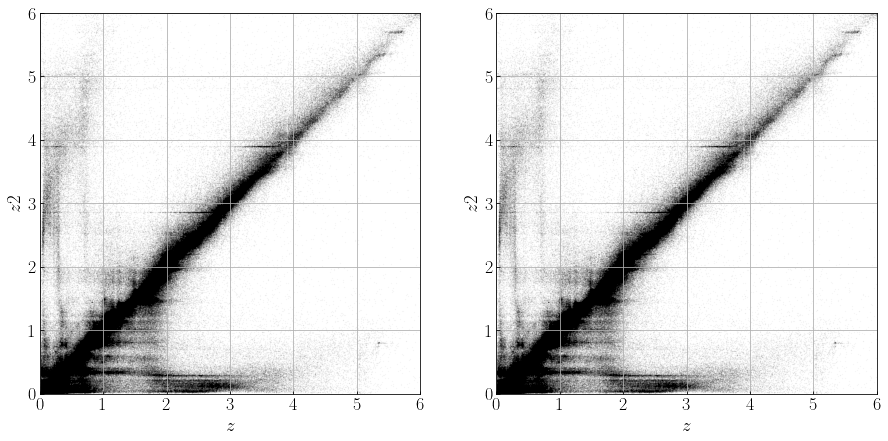

In [10]:
fig, axs = plt.subplots(2, 2, figsize = (15, 7))
for i in [0,1]:
    axs[0].scatter(cat_c20_check['lp_zPDF_1'],cat_c20_check['lp_zPDF_2'],s=0.1,c='k',alpha=0.05)
    axs[0].scatter(cat_c20_check['lp_zPDF_1'],cat_c20_check['ez_z500_1'],s=0.1,c='k',alpha=0.05)
    axs[i].set_xlabel('$z$',fontsize=19)
    axs[i].set_ylabel('$z2$',fontsize=19)
    axs[i].set_xlim([0,6]) 
    axs[i].set_ylim([0,6])
    axs[i].grid()


In [5]:
# add internal checks to C20_CALSSIC catalog

cat_c20_classic = Table.read('/Volumes/LejaySSD/COSMOS2020/COSMOS2020_CLASSIC_R1_v2.0_15bands_photoz_added.fits')
cat_c20_check = Table.read('/Volumes/LejaySSD/COSMOS2020/COSMOS2020_CLASSIC_FARMER_onlymassphotoz_v2.0.fits') 

cat_c20_check_columns = cat_c20_check['flag_photoz','flag_mass','num_of_mass','mass_c20_mean','mass_c20_scatter']

if 'flag_photoz' not in cat_c20_classic.keys():
    cat_c20_classic_new = hstack([cat_c20_classic,cat_c20_check_columns],join_type='exact')
    cat_c20_classic_new.write('/Volumes/LejaySSD/COSMOS2020/COSMOS2020_CLASSIC_R1_v2.0_15bands_photoz_added.fits', overwrite=True)

#### Mass Check Plot

Text(0, 0.5, 'Mass Scatter')

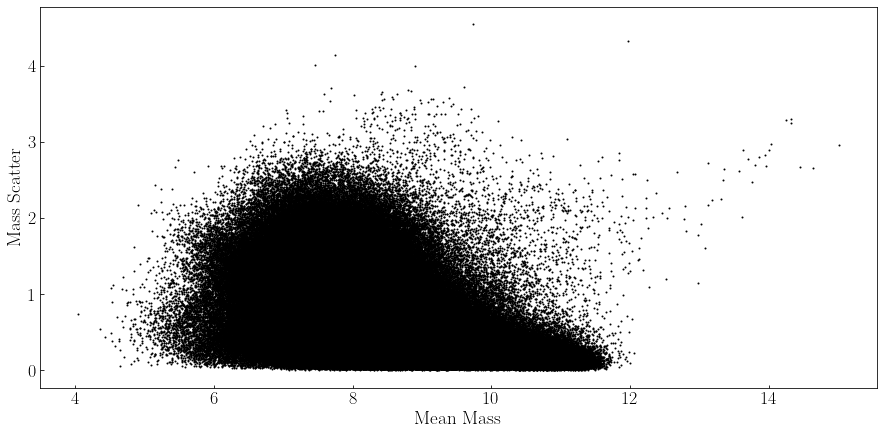

In [12]:
cat_c20_selected = cat_c20_check[cat_c20_check['num_of_mass']==0] # has all four masses
# cat_c20_selected = cat_c20_selected[cat_c20_selected['flag_mass']==1]

fig, axs = plt.subplots(1, 1, figsize = (15, 7),sharex=True, sharey=True)
plt.scatter(cat_c20_selected['mass_c20_mean'],cat_c20_selected['mass_c20_scatter'],s=1,c='k')
plt.xlabel('Mean Mass',fontsize=19)
plt.ylabel('Mass Scatter',fontsize=19)

In [5]:
def percentile_16(arr):
    return np.percentile(arr,16)

def percentile_84(arr):
    return np.percentile(arr,84)

In [25]:
dev_path = '/Users/lejay/research/lephare_dev/my_code/'
output_dir = dev_path+'graham_output_cats/'
cat_name = output_dir+'cat_out_checkdust_nonir_il_22.4_formass.fits'
cat_output_c20added = Table.read(cat_name.replace('.fits','c20added.fits'))
cat_output_c20added = cat_output_c20added[cat_output_c20added['lp_zPDF']>0]
cat_output_c20added = cat_output_c20added[cat_output_c20added['MASS_MED_massrun']>0]
cat_output_c20added = cat_output_c20added[cat_output_c20added['flag_photoz']==1]

cat_output_z = cat_output_c20added[cat_output_c20added['Z_ML']>0.2]
cat_output_z = cat_output_z[cat_output_z['Z_ML']<0.5]

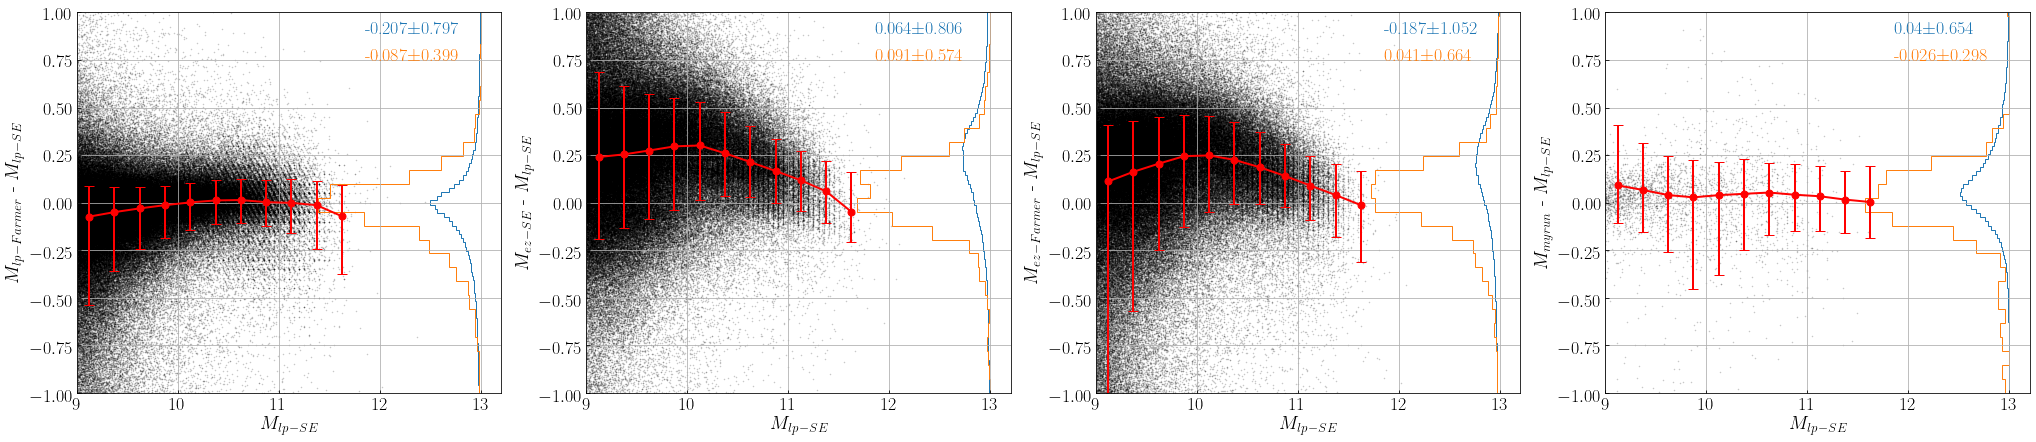

In [13]:
fig, axs = plt.subplots(1, 4, figsize = (35, 7))
y_labels = ['$M_{lp-Farmer}$','$M_{ez-SE}$','$M_{ez-Farmer}$','$M_{myrun}$']
for i,y_mass in enumerate(['lp_mass_med_2','log_ez_mass_1','log_ez_mass_2','m_myrun']):
    if i == 3:
        axs[i].scatter(cat_output_z['lp_mass_med'],cat_output_z['MASS_MED_massrun']-cat_output_z['lp_mass_med'],s=0.3,c='k',alpha=0.2)
    else:
        axs[i].scatter(cat_c20_selected['lp_mass_med_1'],cat_c20_selected[y_mass]-cat_c20_selected['lp_mass_med_1'],s=0.3,c='k',alpha=0.2)
    
    axs[i].set_xlabel(r'$M_{lp-SE}$',fontsize=19)
    axs[i].set_ylabel(y_labels[i]+' - '+'$M_{lp-SE}$',fontsize=19)
    axs[i].set_xlim([9,13.2]) 
    axs[i].set_ylim([-1,1])
    axs[i].grid()

    # running median
    step=0.25
    if i==3:
        x = cat_output_c20added['lp_mass_med']
        y = cat_output_c20added['MASS_MED_massrun']-cat_output_c20added['lp_mass_med']
        y_massive_gal = y[cat_output_c20added['lp_mass_med']>11.2]
    else:
        x=cat_c20_selected['lp_mass_med_1']
        y=cat_c20_selected[y_mass]-cat_c20_selected['lp_mass_med_1']
        y_massive_gal = y[cat_c20_selected['lp_mass_med_1']>11.2]
    
    # statistics
    medians,bin_edges,bin_numbers = binned_statistic(x, y, statistic='median', bins=np.arange(9,12,step))
    per16,bin_edges,bin_numbers = binned_statistic(x, y, statistic=percentile_16, bins=np.arange(9,12,step))
    per84,bin_edges,bin_numbers = binned_statistic(x, y, statistic=percentile_84, bins=np.arange(9,12,step))
    axs[i].errorbar(bin_edges[:-1]+step/2,medians,yerr=[medians-per16,per84-medians],fmt='o-',color='r',linewidth=2,capsize=5,markersize=7)
    
    # std error
    axs[i].annotate(str(round(np.nanmean(y),3))+'$\pm$'+str(round(np.nanstd(y),3)),xy=([0.68,0.95]),xycoords='axes fraction',fontsize=  18,color='tab:blue')
    axs[i].annotate(str(round(np.nanmean(y_massive_gal),3))+'$\pm$'+str(round(np.nanstd(y_massive_gal),3)),xy=([0.68,0.88]),xycoords='axes fraction',fontsize=18,color='tab:orange')
    
    # histogram for delta_M
    axs[i].hist(y,bins=100,range=(-1,1.2),orientation='horizontal',weights=-10*np.ones(len(y))/len(y),bottom=13,histtype='step')
    axs[i].hist(y_massive_gal,bins=30,range=(-1,1.2),orientation='horizontal',weights=-8*np.ones(len(y_massive_gal))/len(y_massive_gal),bottom=13,histtype='step')

In [4]:
from scipy.optimize import curve_fit

def gaussian(x, a, mu, sigma):
    return a * np.exp(-np.power(x - mu, 2.) / (2 * np.power(sigma, 2.)))


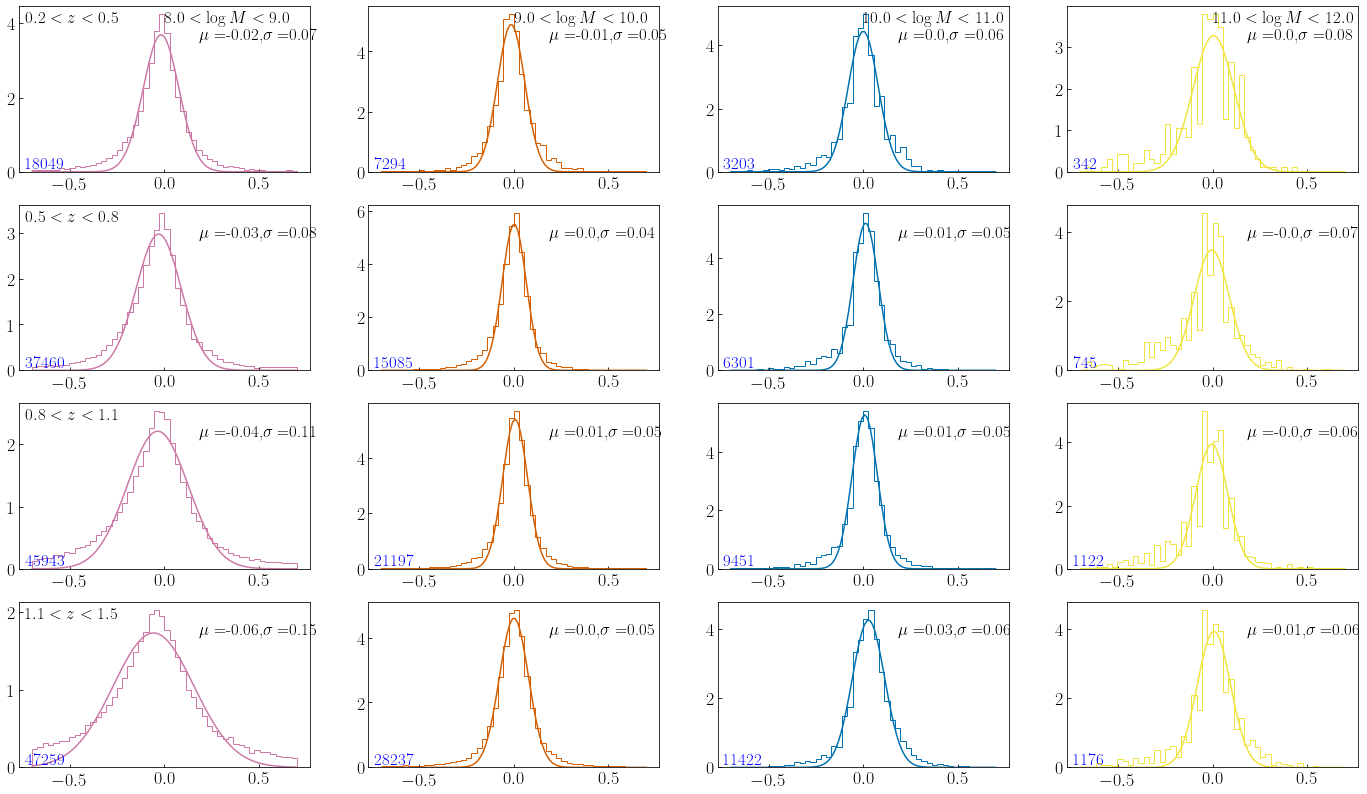

In [32]:
z_mins = [0.2, 0.5, 0.8, 1.1]
z_maxs = [0.5, 0.8, 1.1, 1.5]
mass_bins = [[8.0,9.0],[9.0,10.0],[10.,11.0],[11.0,12.0]]


cat_c20_check = Table.read('/Volumes/LejaySSD/COSMOS2020/COSMOS2020_CLASSIC_FARMER_onlymassphotoz_v2.0.fits')
cat_c20_selected = cat_c20_check[cat_c20_check['num_of_mass']==0] # has all four masses
sfq = 'sf' # CLASS 0==q, 1==sf

fig, axs = plt.subplots(len(z_mins), len(mass_bins), figsize = (len(mass_bins)*6, len(z_mins)*3.5))
for i,z_min in enumerate(z_mins):
    row = i // 2; col = i % 2
    cat_z = cat_c20_selected[cat_c20_selected['lp_zPDF_1']>z_mins[i]]
    cat_z = cat_z[cat_z['lp_zPDF_1']<z_maxs[i]]
    
    if sfq =='sf':
        cat_z = cat_z[cat_z['CLASS']==1]
    elif sfq == 'q':
        cat_z = cat_z[cat_z['CLASS']==0]
    
    colors = ['#CC79A7','#D55E00','#0072B2','#F0E442','#009E73','#56B4E9','#E69F00']
    axs[i][0].annotate('$'+str(z_mins[i])+'<z<'+str(z_maxs[i])+'$',xy=([0.02,0.9]),xycoords='axes fraction',fontsize=17,color='k')
    for k,mass_bin in enumerate(mass_bins):
        if i==0: axs[0][k].annotate('$'+str(mass_bin[0])+' <\log M <'+str(mass_bin[1])+'$',xy=([0.5,0.9]),xycoords='axes fraction',fontsize=17,color='k')
        
        cat_z_mass = cat_z[np.logical_and(cat_z['lp_mass_med_1']>mass_bin[0],cat_z['lp_mass_med_1']<mass_bin[1])]
        axs[i][k].annotate(str(len(cat_z_mass)),xy=([0.02,0.02]),xycoords='axes fraction',fontsize=17,color='b')
        
        y = np.array(cat_z_mass['lp_mass_med_2'] - cat_z_mass['lp_mass_med_1'])
        y[np.isnan(y)]=-99
        n,bins,patches = axs[i][k].hist(y, bins=50, density=True, range=(-0.7,0.7), histtype='step', color=colors[k])
        
        # Gaussian fit
        popt,pcov = curve_fit(gaussian, bins[:-1]+(bins[1]-bins[0])/2, n,p0=[100,0,0.1])
        axs[i][k].annotate('$\mu=$'+str(round(popt[1],2))+',$\sigma=$'+str(round(popt[2]/np.sqrt(2),2)),xy=([0.62,0.8]),xycoords='axes fraction',fontsize=17,color='k')
        x_plot = np.linspace(-0.7,0.7,100)
        axs[i][k].plot(x_plot,gaussian(x_plot,popt[0],popt[1],popt[2]),color=colors[k])


In [36]:
mass_bins = np.array([[8.0,9.0],[9.0,10.0],[10.,11.0],[11.0,12.0]])
sfq = 'all' # CLASS 0==q, 1==sf

for i,z_min in enumerate(z_mins):
    z_max = z_maxs[i]
    cat_z = cat_c20_selected[cat_c20_selected['lp_zPDF_1']>z_min]
    cat_z = cat_z[cat_z['lp_zPDF_1']<z_max]
    
    if sfq =='sf':
        cat_z = cat_z[cat_z['CLASS']==1]
    elif sfq == 'q':
        cat_z = cat_z[cat_z['CLASS']==0]

    mass_mu_list = []
    mass_sigma_list = []
    for k,mass_bin in enumerate(mass_bins):
        mass_min = mass_bin[0]
        mass_max = mass_bin[1]
        cat_z_mass = cat_z[np.logical_and(cat_z['lp_mass_med_2']>mass_min,cat_z['lp_mass_med_2']<mass_max)]
        
        # Fitting mass error distribution
        mass_diff = np.array(cat_z_mass['lp_mass_med_2'] - cat_z_mass['lp_mass_med_1'])
        mass_diff[np.isnan(mass_diff)]=-99
    
        # Gaussian fit
        n,bins = np.histogram(mass_diff, bins=50, range=(-0.7,0.7))
        popt,pcov = curve_fit(gaussian, bins[:-1]+(bins[1]-bins[0])/2, n,p0=[100,0,0.1])
        
            
        # mass error
        mass_mu_list.append(popt[1])
        mass_sigma_list.append(popt[2]/np.sqrt(2))
        
    mass_err_list = np.stack([mass_bins[:,0], mass_mu_list, mass_sigma_list])
    np.save('mass_err/mass_err_C20_'+str(sfq)+'_'+str(z_min)+'.npy',mass_err_list)
    print(mass_err_list)
            

[[ 8.000e+00  9.000e+00  1.000e+01  1.100e+01]
 [-1.300e-02 -8.934e-03  5.442e-03  5.308e-02]
 [ 6.557e-02 -5.086e-02  5.486e-02  7.943e-02]]
[[ 8.000e+00  9.000e+00  1.000e+01  1.100e+01]
 [-2.122e-02  5.618e-03  1.719e-02  3.007e-02]
 [ 7.697e-02  4.360e-02  4.698e-02  6.663e-02]]
[[ 8.000e+00  9.000e+00  1.000e+01  1.100e+01]
 [-2.574e-02  1.078e-02  1.196e-02  2.437e-02]
 [ 9.935e-02  4.587e-02  4.783e-02  5.622e-02]]
[[ 8.000e+00  9.000e+00  1.000e+01  1.100e+01]
 [-5.707e-02  5.986e-03  3.355e-02  4.914e-02]
 [ 1.209e-01  5.217e-02  5.970e-02  7.248e-02]]


(-1, 1)

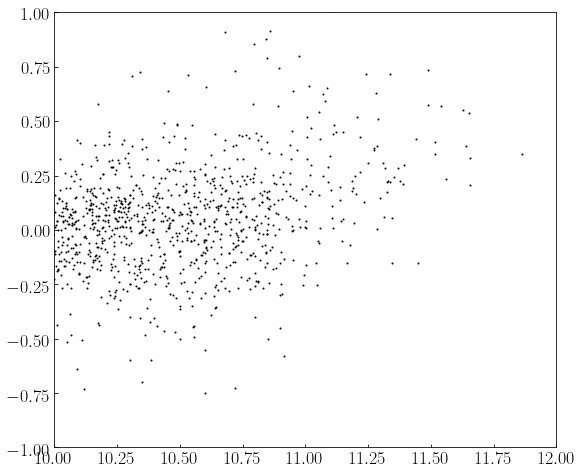

In [33]:
fig, axs = plt.subplots(1, 1, figsize = (9, 8), sharey=True)
plt.scatter(cat_output_z['MASS_MED_massrun'],cat_output_z['MASS_MED_massrun']-cat_output_z['lp_mass_med'],s=1,c='k',alpha=1)
plt.xlim([10,12])
plt.ylim([-1,1])

(-1, 1)

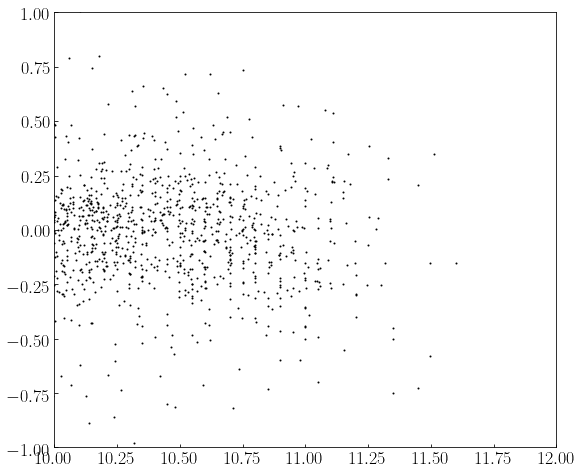

In [34]:
fig, axs = plt.subplots(1, 1, figsize = (9, 8), sharey=True)
plt.scatter(cat_output_z['lp_mass_med'],cat_output_z['MASS_MED_massrun']-cat_output_z['lp_mass_med'],s=1,c='k',alpha=1)
plt.xlim([10,12])
plt.ylim([-1,1])

#### add CLASS (sfq classfication) to COSMOS2020 v2.0 catalog

$M_{NUV} - M_r > 3 (M_r -M_J)+1$

$M_{NUV} - M_r>3.1$


In [6]:
cat = Table.read('/Volumes/LejaySSD/COSMOS2020/COSMOS2020_CLASSIC_R1_v2.0_15bands_photoz_added.fits')

# lp_MNUV, lp_MR, lp_MJ
# 0==q, 1==sf
cond1 = cat['lp_MNUV'] - cat['lp_MR'] < 3*(cat['lp_MR'] - cat['lp_MJ']) + 1
cond2 = cat['lp_MNUV'] - cat['lp_MR'] < 3.1
CLASS = (cond1|cond2).astype(int)

In [7]:
class_col = Column(data=CLASS, name='CLASS')
cat.add_column(class_col)
cat.write('/Volumes/LejaySSD/COSMOS2020/COSMOS2020_CLASSIC_R1_v2.0_15bands_photoz_sfq_added.fits', overwrite=True)

#### NUVrK plot with FARMER abs. mags and SExtractor classification
both with abs. magnitudes estimated with LePhare

In [2]:
def gv_boundary_2(color1, ic_1, ic_2, slope):
    nuv_1 = ic_1
    nuv_2 = slope*color1 + ic_2
    return np.maximum(nuv_1, nuv_2)

In [49]:
# match 2 CLASSIC and FARMER original catalogs
# keep only lp abs. mag columns
cat_c20_classic = '/Volumes/LejaySSD/COSMOS2020/COSMOS2020_CLASSIC_R1_v2.0.fits'
cat_c20_farmer = '/Volumes/LejaySSD/COSMOS2020/COSMOS2020_FARMER_R1_v2.0.fits'
combined_cat_name = '/Volumes/LejaySSD/COSMOS2020/COSMOS2020_CLASSIC_FARMER_onlyabsmag_v2.0.fits'
join = 'all1'

# matching cat_output and cat_c20
col_list = "'lp_MNUV_* lp_MR_* lp_MK_* lp_MJ_* lp_zPDF_* lp_mass_med_* HSC_i_MAG_AUTO HSC_i_MAG ez_restU* ez_restV* ez_restJ*'"
cmd = 'java -jar stilts.jar tmatch2 in1='+cat_c20_classic + ' in2='+cat_c20_farmer+' find=best join='+join+\
      ' matcher=sky params=0.1 values1="ALPHA_J2000 DELTA_J2000"  values2="ALPHA_J2000 DELTA_J2000" suffix1=_classic suffix2=_farmer out='+\
      combined_cat_name +' ocmd="keepcols '+col_list+'"'
print(cmd)
os.system(cmd)

# # add CLASS info
cat_combined = Table.read(combined_cat_name)
cat_combined.add_column(class_col)
cat_combined.write(combined_cat_name, overwrite=True)

java -jar stilts.jar tmatch2 in1=/Volumes/LejaySSD/COSMOS2020/COSMOS2020_CLASSIC_R1_v2.0.fits in2=/Volumes/LejaySSD/COSMOS2020/COSMOS2020_FARMER_R1_v2.0.fits find=best join=all1 matcher=sky params=0.1 values1="ALPHA_J2000 DELTA_J2000"  values2="ALPHA_J2000 DELTA_J2000" suffix1=_classic suffix2=_farmer out=/Volumes/LejaySSD/COSMOS2020/COSMOS2020_CLASSIC_FARMER_onlyabsmag_v2.0.fits ocmd="keepcols 'lp_MNUV_* lp_MR_* lp_MK_* lp_MJ_* lp_zPDF_* lp_mass_med_* HSC_i_MAG_AUTO HSC_i_MAG ez_restU* ez_restV* ez_restJ*'"


In [4]:
combined_cat_name = '/Volumes/LejaySSD/COSMOS2020/COSMOS2020_CLASSIC_FARMER_onlyabsmag_v2.0.fits'
cat = Table.read(combined_cat_name)
cat = cat[cat['lp_zPDF_classic']>0]
cat = cat[cat['lp_mass_med_classic']>6]
cat = cat[cat['HSC_i_MAG_AUTO']>17]
cat = cat[cat['HSC_i_MAG_AUTO']<26]
select_ids = np.random.choice(np.arange(len(cat)), size=100000,replace=False)
cat = cat[select_ids]

In [5]:
for key in cat.keys():
    if 'ez_rest' in key:
        mag=2.5*(23-np.log10(cat[key]/1e6))-48.6
        mag_col = Column(data=mag,name='mag_'+key)
        cat.add_column(mag_col)

/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


In [66]:
# selection box from Williams+2019 (0.5<z<1.0)
def uvj_box(uv,vj): # return 1 if quiescent
    uv = np.array(uv)
    vj = np.array(vj)
    cond1 = (uv>0.88*vj+0.59)
    cond2 = (uv>1.3)
    cond3 = (vj<1.6)
    return (cond1*cond2*cond3).astype(int)

In [13]:
from texttable import *

    | $f_{c,sf}$ | $f_{m,sf}$ | $f_{c,q}$ | $f_{m,q}$
====+============+============+===========+==========
C20 |   1.6\%    |   2.3\%    |  20.9\%   |  14.4\%  


[]

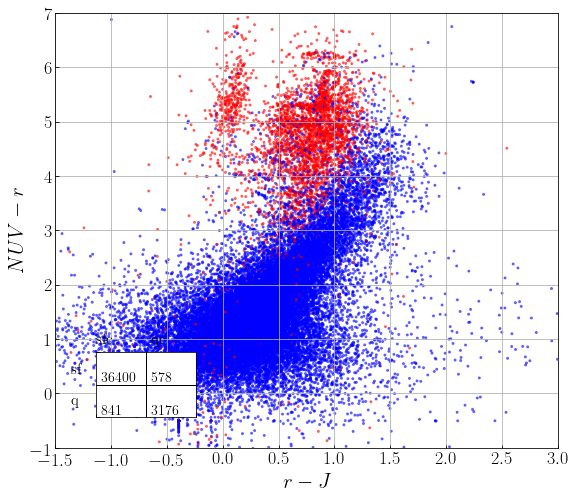

In [18]:
suffix='_farmer'
plot_type='J' # K or J

fig, axs = plt.subplots(1, 1, figsize = (9, 8), sharey=True)
plt.scatter(cat['lp_MR'+suffix]-cat['lp_M'+plot_type+suffix], cat['lp_MNUV'+suffix]-cat['lp_MR'+suffix],s=4,c=cat['CLASS'],alpha=0.5,cmap='bwr_r')
plt.xlabel(r'$r-'+plot_type+'$',fontsize=21)
plt.ylabel(r'$NUV-r$',fontsize=21)
plt.xlim([-1.5,3])
plt.ylim([-1,7])
plt.grid()

#### contingency table / confusion matrix (inset plot 2) ######
# q=P sf=N
cat_sf = cat[cat['CLASS']==1]
cat_q = cat[cat['CLASS']==0]
best_box_c20 = [3.1, 1, 3]
 
rj_sf = np.array(cat_sf['lp_MR'+suffix] - cat_sf['lp_M'+plot_type+suffix])
rj_q = np.array(cat_q['lp_MR'+suffix] - cat_q['lp_M'+plot_type+suffix]) 
delta_gv_sf = cat_sf['lp_MNUV'+suffix] - cat_sf['lp_MR'+suffix]-gv_boundary_2(rj_sf,best_box_c20[0],best_box_c20[1],best_box_c20[2])
delta_gv_q = cat_q['lp_MNUV'+suffix] - cat_q['lp_MR'+suffix]-gv_boundary_2(rj_q,best_box_c20[0],best_box_c20[1],best_box_c20[2])

sf_sf = len(cat_sf[delta_gv_sf<0])  # TN
q_q = len(cat_q[delta_gv_q>0])      # TP
sf_q = len(cat_q[delta_gv_q<0])     # FP
q_sf = len(cat_sf[delta_gv_sf>0])   # FN

f_c_sf = sf_q / (sf_q+sf_sf)
f_m_sf = q_sf / (sf_q+sf_sf)
f_c_q = q_sf / (q_q+q_sf)
f_m_q = sf_q / (q_q+q_sf)
tab_rows = [[' ','$f_{c,sf}$','$f_{m,sf}$','$f_{c,q}$','$f_{m,q}$']]
tab_rows.append(['C20',str(round(f_c_sf*100,1))+'\%',str(round(f_m_sf*100,1))+'\%',
                         str(round(f_c_q*100,1))+'\%',str(round(f_m_q*100,1))+'\%'])
table = Texttable()
table.set_cols_align(["c"] * 5)
table.set_deco(Texttable.HEADER | Texttable.VLINES)
table.add_rows(tab_rows)
print(table.draw())

# inset table
plt.annotate('sfc',xy=([0.08,0.24]),xycoords='axes fraction',fontsize=15)
plt.annotate('qc',xy=([0.19,0.24]),xycoords='axes fraction',fontsize=15)
plt.annotate('sf',xy=([0.03,0.17]),xycoords='axes fraction',fontsize=15)
plt.annotate('q',xy=([0.03,0.1]),xycoords='axes fraction',fontsize=15)
ax_insert2 = axs.inset_axes([0.08, 0.07, 0.2, 0.15])
ax_insert2.annotate(str(sf_sf),xy=([-0.9,0.1]),fontsize=14)
ax_insert2.annotate(str(sf_q),xy=([0.1,0.1]),fontsize=14)
ax_insert2.annotate(str(q_sf),xy=([-0.9,-0.9]),fontsize=14)
ax_insert2.annotate(str(q_q),xy=([0.1,-0.9]),fontsize=14)
ax_insert2.axvline(ymin=-1,ymax=1,x=0,color='k',linewidth=1)
ax_insert2.axhline(xmin=-1,xmax=1,y=0,color='k',linewidth=1)
ax_insert2.set_xlim([-1,1])
ax_insert2.set_ylim([-1,1])
ax_insert2.set_yticklabels([])
ax_insert2.set_xticklabels([])

/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in greater
  after removing the cwd from sys.path.
/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in greater
  """
/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in less
  


[]

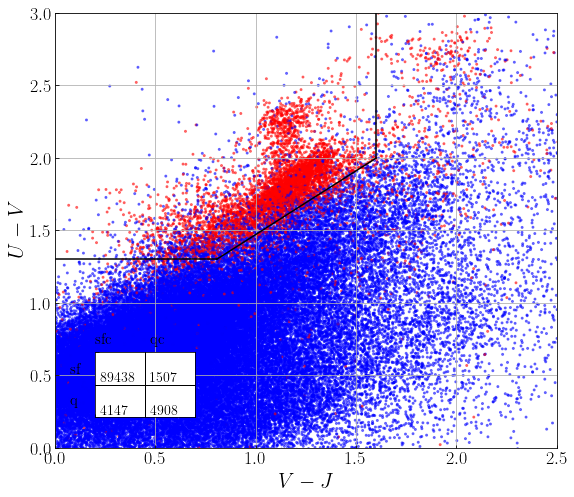

In [90]:
suffix='_classic'

fig, axs = plt.subplots(1, 1, figsize = (9, 8), sharey=True)
plt.scatter(cat['mag_ez_restV'+suffix]-cat['mag_ez_restJ'+suffix], cat['mag_ez_restU'+suffix]-cat['mag_ez_restV'+suffix],s=4,c=cat['CLASS'],alpha=0.5,cmap='bwr_r')
plt.xlabel(r'$V-J$',fontsize=21)
plt.ylabel(r'$U-V$',fontsize=21)
plt.xlim([0,2.5])
plt.ylim([0,3])
plt.grid()

#### contingency table / confusion matrix (inset plot 2) ######
# q=P sf=N
cat_sf = cat[cat['CLASS']==1]
cat_q = cat[cat['CLASS']==0]

uv_sf = np.array(cat_sf['mag_ez_restU'+suffix] - cat_sf['mag_ez_restV'+suffix])
uv_q = np.array(cat_q['mag_ez_restU'+suffix] - cat_q['mag_ez_restV'+suffix]) 
vj_sf = np.array(cat_sf['mag_ez_restV'+suffix] - cat_sf['mag_ez_restJ'+suffix])
vj_q = np.array(cat_q['mag_ez_restV'+suffix] - cat_q['mag_ez_restJ'+suffix]) 

sf_sf = len(cat_sf[uvj_box(uv_sf,vj_sf)==0]) # TN
q_q = len(cat_q[uvj_box(uv_q,vj_q)==1])      # TP
sf_q = len(cat_sf[uvj_box(uv_sf,vj_sf)==1])   # FP
q_sf = len(cat_q[uvj_box(uv_q,vj_q)==0])  # FN


vj_draw = np.linspace(0,1.6,100)
x1,y1 = (1.3-0.59)/0.88,1.3
x2,y2 = 1.6,0.88*1.6+0.59
plt.plot([0,x1],[1.3,1.3],color='k')
plt.plot([x1,x2],[y1,y2],color='k')
plt.plot([1.6,1.6],[y2,3],color='k')
    
# inset table
plt.annotate('sfc',xy=([0.08,0.24]),xycoords='axes fraction',fontsize=15)
plt.annotate('qc',xy=([0.19,0.24]),xycoords='axes fraction',fontsize=15)
plt.annotate('sf',xy=([0.03,0.17]),xycoords='axes fraction',fontsize=15)
plt.annotate('q',xy=([0.03,0.1]),xycoords='axes fraction',fontsize=15)
ax_insert2 = axs.inset_axes([0.08, 0.07, 0.2, 0.15])
ax_insert2.annotate(str(sf_sf),xy=([-0.9,0.1]),fontsize=14)
ax_insert2.annotate(str(sf_q),xy=([0.1,0.1]),fontsize=14)
ax_insert2.annotate(str(q_sf),xy=([-0.9,-0.9]),fontsize=14)
ax_insert2.annotate(str(q_q),xy=([0.1,-0.9]),fontsize=14)
ax_insert2.axvline(ymin=-1,ymax=1,x=0,color='k',linewidth=1)
ax_insert2.axhline(xmin=-1,xmax=1,y=0,color='k',linewidth=1)
ax_insert2.set_xlim([-1,1])
ax_insert2.set_ylim([-1,1])
ax_insert2.set_yticklabels([])
ax_insert2.set_xticklabels([])

